In [141]:
import jax 
import jax.numpy as jnp
import haiku as hk
import numpy as np
import matplotlib.pyplot as plt
import optax
from tqdm import tqdm

In [30]:
def cost_fn(x, y):
    return jnp.sqrt(jnp.sum(jnp.square(x - y)))


def weight_clipping(params, x, y):
    f_x = descriminator.apply(params, x)
    f_y = descriminator.apply(params, y)
    
    return jnp.mean(f_x - f_y)


def gradient_penality(params, lmb, x, y, z):
    f_x = descriminator.apply(params, x)
    f_y = descriminator.apply(params, y)
    
    grad_z = jax.grad(descriminator)(z)
    grad_pen = jnp.square(1 - jnp.linalg.norm(grad_Z))
    
    return f_x - f_y - lmb*grad_pen


def c_transform(params, all_x, x, y):
    f_x = descriminator.apply(params, x)
    
    cost_fn_all_x = jax.vmap(cost_fn, in_axes=(1, None))
    descriminator_all_x = jax.vmap(descriminator, in_axes=(None, 1))
    A = cost_fn_all_x(all_x, y) - descriminator_all_x(params, all_x)
    f_y = jnp.min(A)
    
    return f_x - f_y


def c_eps_transform(params, all_x, eps, x, y):
    f_x = descriminator.apply(params, x)
    
    cost_fn_all_x = jax.vmap(cost_fn, in_axes=(1, None))
    descriminator_all_x = jax.vmap(descriminator, in_axes=(None, 1))
    A = cost_fn_all_x(all_x, y) - descriminator_all_x(params, all_x)
    f_y = -eps*jnp.log(jnp.mean(jnp.exp(A/eps)))
    
    return f_x - f_y

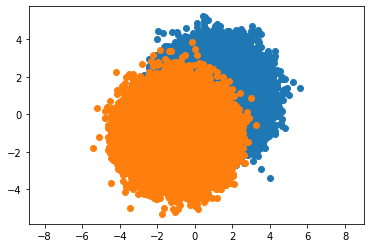

In [180]:
# Distribution 1
def dist_1(rng_key, nb_samples, nb_epoch):
    return jax.random.multivariate_normal(rng_key, 
                                          mean=jnp.array([1,1]), 
                                          cov=jnp.eye(2),
                                          shape=[nb_epoch, nb_samples,])


# Distribution 2
def dist_2(rng_key, nb_samples, nb_epoch):
    return jax.random.multivariate_normal(rng_key, 
                                          mean=jnp.array([-1,-1]), 
                                          cov=jnp.eye(2),
                                          shape=[nb_epoch, nb_samples,])
# Sample from each distribution
nb_samples = 100000
x_key, y_key = jax.random.split(rng)
x = dist_1(x_key, nb_samples, 1)[0]
y = dist_2(y_key, nb_samples, 1)[0]

plt.plot(x[:,0], x[:, 1], 'o')
plt.plot(y[:,0], y[:, 1], 'o')
plt.axis('equal');

In [194]:
def descriminator(x):
    mlp = hk.nets.MLP([128, 128, 1])
    return mlp(x)


descriminator = hk.transform(descriminator)
descriminator = hk.without_apply_rng(descriminator)

# Generation des données
nb_samples = 64
nb_epoch = 5000
rng_key = jax.random.PRNGKey(42)

params_key, x_key, y_key = jax.random.split(rng_key, 3)
all_x = dist_1(x_key, nb_samples, nb_epoch)
all_y = dist_2(y_key, nb_samples, nb_epoch)

# Initalisation du modèle
params = descriminator.init(params_key, all_x[0])

# Loss et gradient
value_loss = jax.value_and_grad(loss_weight_clipping)

c = 0.01
@jax.jit
def step(params, opt_state, x, y):
    loss, gradient = value_loss(params, x, y)
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    
    # Minus before updates as we want gradient ascent 
    params = optax.apply_updates(params, jax.tree_map(lambda x: -x, updates))
    params = jax.tree_map(lambda x: jnp.clip(x, -c, c), params)
    
    return params, opt_state, loss

# Training
optimizer = optax.rmsprop(1e-5)
opt_state = optimizer.init(params)

loss_list = []
for i in tqdm(range(nb_epoch)):
    x, y = all_x[i], all_y[i]
    
    params, opt_state, loss = step(params, opt_state, x, y)
    if i % 10 == 0:
        loss_list.append(loss)

100% 500/500 [00:01<00:00, 348.06it/s]


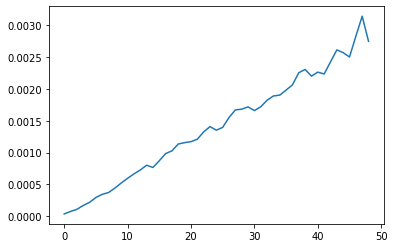

In [195]:
plt.plot(loss_list[1:]);